In [1]:
import pyspark
import findspark
import pandas as pd
import matplotlib.pyplot as plt
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

Построить гистограмму количества звонков в техническую поддержку

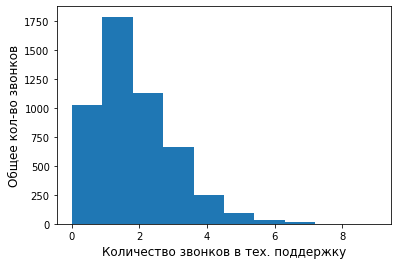

In [36]:
df = pd.read_csv('churn.csv')
plt.hist(df[['number_customer_service_calls']])
plt.xlabel('Количество звонков в тех. поддержку', fontsize = 12)
plt.ylabel('Общее кол-во звонков', fontsize = 12)
plt.show()

Рассчитать и построить гистограмму общей длительности звонков клиента (дневных + ночных + вечерних + международных)

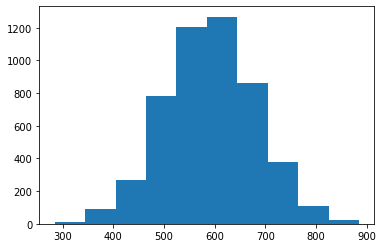

In [29]:
plt.hist((df['total_day_minutes']+df['total_eve_minutes']+df['total_night_minutes']+df['total_intl_minutes']))
plt.show()

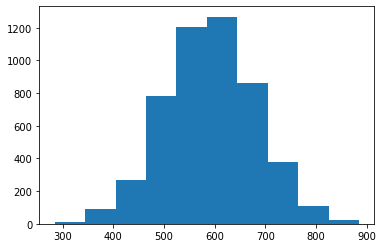

In [32]:
plt.hist(df[['total_day_minutes', 'total_eve_minutes', 'total_night_minutes', 'total_intl_minutes']].sum(axis=1))
plt.show()

Собственноручно (не используя встроенных функций) рассчитать линейный коэффициент корреляции (доп. материалы общего количества минут и количества звонков в техподдержку

In [38]:
df[['total_day_minutes', 'total_eve_minutes', 'total_night_minutes', 'total_intl_minutes']].sum(axis=1).corr(df['number_customer_service_calls'])

-0.011407910827441433

Визуализировать точечный график по общему количеству минут / количеству звонков в поддержку, подкрасив точки в зависимости от оттока абонента

In [39]:
df['minutes'] = df[['total_day_minutes', 'total_eve_minutes', 'total_night_minutes', 'total_intl_minutes']].sum(axis=1)

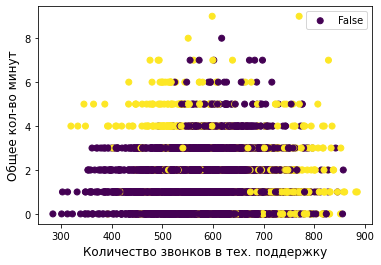

In [100]:
plt.scatter(df['minutes'], df['number_customer_service_calls'], c=df['churned'])
plt.legend(df['churned'])
plt.xlabel('Количество звонков в тех. поддержку', fontsize = 12)
plt.ylabel('Общее кол-во минут', fontsize = 12)
plt.show()

Вывести top-5 самых много и самых мало говорящих клиентов

In [70]:
df[['minutes']].sort_values(by='minutes', ascending=False).head(5)

,minutes
985,885.0
289,882.2
3205,860.2
4991,858.2
4271,857.4


In [69]:
df[['minutes']].sort_values(by='minutes').head(5)

,minutes
648,284.3
1233,301.5
3779,303.2
1986,313.0
992,313.3


Вывести долю оттока клиентов и среднюю стоимость минуты дневного времени разговора в зависимости от штата

In [84]:
per_of_churn = round(df['churned'].count() / (df['churned'].value_counts()[1] * 100) * 100, 3)
print(f'Доля оттока клиентов: {per_of_churn}%')

Доля оттока клиентов: 7.072%


In [106]:
df['cost_per_min_day'] = df['total_day_charge'] / df['total_day_minutes']
df.groupby('state')[['churned', 'cost_per_min_day']].agg('mean').sort_values(by='churned', ascending=False).head()

,churned,cost_per_min_day
state,,
CA,0.269231,0.170003
NJ,0.250000,0.170001
WA,0.244898,0.170002
TX,0.224138,0.170003
MT,0.212121,0.170001


Перевести штат в one-hot формат при помощи pandas-функции get_dummies или удалить колонку, если вы делаете решение на pyspark

In [98]:
pd.get_dummies(df, columns=['state'], drop_first=True)

,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,...,0,0,0,0,0,0,0,0,0,0
1,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,...,0,0,0,0,0,0,0,0,0,0
2,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,...,0,0,0,0,0,0,0,0,0,0
3,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,...,0,0,0,0,0,0,0,0,0,0
4,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,50,408,365-8751,no,yes,40,235.7,127,40.07,223.0,...,0,0,0,0,0,0,0,0,0,0
4996,152,415,334-9736,no,no,0,184.2,90,31.31,256.8,...,0,0,0,0,0,0,0,0,1,0
4997,61,415,333-6861,no,no,0,140.6,89,23.90,172.8,...,0,0,0,0,0,0,0,0,0,0
4998,109,510,394-2206,no,no,0,188.8,67,32.10,171.7,...,0,0,0,0,0,0,0,0,0,0


Разбить данные на множества для обучения и для проверки, отобрав признаки для обучения модели классификации (убрать номер телефона, код региона, признаки планов + все добавленные атрибуты)

Обучить какую-нибудь модель классификации и оценить качество (точность) на отложенной выборке